# Models definition and testing

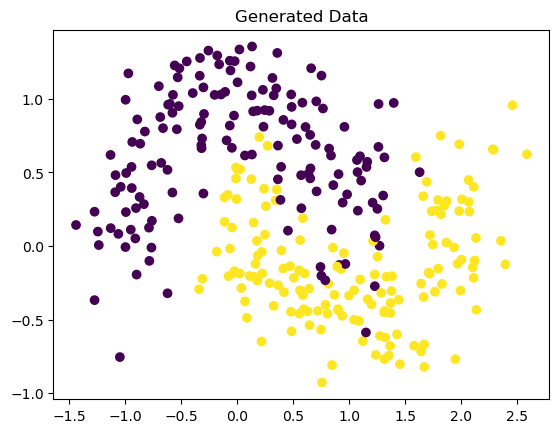

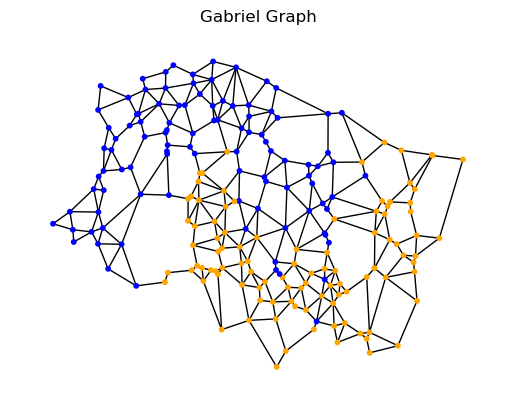

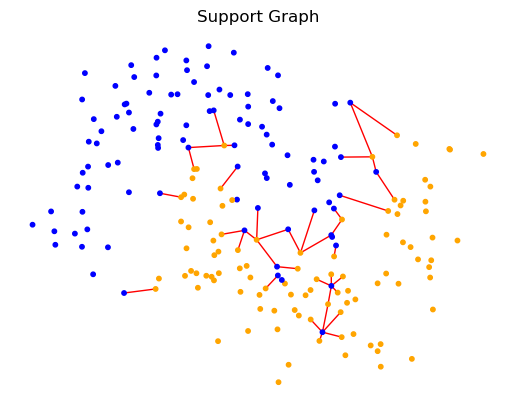

In [156]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from enum import IntEnum
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

def sq_distance(a: np.ndarray, b: np.ndarray) -> float:
  """
  Calculate the squared distance between two vectors.
  
  Parameters:
  a (np.ndarray): First vector.
  b (np.ndarray): Second vector.
  
  Returns:
  float: Squared distance between the two vectors.
  """
  return np.sum((a - b) ** 2)

def kernel(X: np.ndarray, Y: np.ndarray, cov: np.ndarray) -> np.ndarray:
  """
  Calculate the kernel values between two sets of vectors using a Gaussian kernel.
  
  Parameters:
  X (np.ndarray): First set of vectors (n_samples_X, n_features).
  Y (np.ndarray): Second set of vectors (n_samples_Y, n_features).
  cov (np.ndarray): Covariance matrix for the Gaussian kernel.
  
  Returns:
  np.ndarray: Kernel values between the two sets of vectors (n_samples_X, n_samples_Y).
  """
  n = X.shape[1]
  factor = 1 / (np.sqrt((2 * np.pi) ** n * np.linalg.det(cov)))
  inv_cov = np.linalg.inv(cov)
  diff = X[:, None, :] - Y[None, :, :]
  exponent = -0.5 * np.einsum('ijk,kl,ijl->ij', diff, inv_cov, diff)
  return factor * np.exp(exponent)

def distance_matrix(X: np.ndarray) -> np.ndarray:
  """
  Compute the squared distance matrix for a set of points.
  
  Parameters:
  X (np.ndarray): Array of points.
  
  Returns:
  np.ndarray: Squared distance matrix.
  """
  return cdist(X, X, metric='sqeuclidean')
                    
class Adjacency(IntEnum):
  NOT_ADJACENT = 0,
  GABRIEL_EDGE = 1,
  SUPPORT_EDGE = 2

def gabriel_graph(distance_matrix: np.ndarray) -> np.ndarray:
  """
  Create a Gabriel graph from a distance matrix using the correct condition.

  Let E be an possible edge between points xi and xj.
  E ∈ G <-> ∀k ∈ V \\ {xi, xj} : d^2(xi, xj) ≤ d^2(xi, xk) + d^2(xj, xk)

  Parameters:
  distance_matrix (np.ndarray): Squared distance matrix.

  Returns:
  np.ndarray: Adjacency matrix of the Gabriel graph.
  """
  n = distance_matrix.shape[0]
  adjacency_matrix = np.zeros((n, n), dtype=int)

  for i in range(n):
    for j in range(i + 1, n):
      d_ij = distance_matrix[i, j]
      d_ik = distance_matrix[i, :]
      d_jk = distance_matrix[j, :]
      valid = np.all((d_ik + d_jk) >= d_ij)
      if valid:
        adjacency_matrix[i, j] = Adjacency.GABRIEL_EDGE
        adjacency_matrix[j, i] = Adjacency.GABRIEL_EDGE

  return adjacency_matrix

def support_graph(gabriel_graph: np.ndarray, y: np.ndarray) -> np.ndarray:
  """
  Create a support graph from a Gabriel graph and the vector of labels.

  An edge is a support edge if its vertices belong to different classes.

  Parameters:
  gabriel_graph (np.ndarray): Adjacency matrix of the Gabriel graph.
  y (np.ndarray): Vector of labels.

  Returns:
  np.ndarray: Adjacency matrix of the support graph with enum values.
  """
  n = gabriel_graph.shape[0]
  support_graph = np.zeros((n, n), dtype=int)

  gabriel_edges = gabriel_graph > 0

  different_labels = y[:, None] != y[None, :]

  support_graph[gabriel_edges & different_labels] = Adjacency.SUPPORT_EDGE

  support_graph[gabriel_edges & ~different_labels] = Adjacency.GABRIEL_EDGE

  return support_graph

def plot_graph(X: np.ndarray, graph: np.ndarray, y: np.ndarray, type: str='gabriel') -> None:
  """
  Plot a graph with vertices colored based on labels and edges colored based on their type.

  Parameters:
  X (np.ndarray): Coordinates of the vertices.
  graph (np.ndarray): Adjacency matrix of the graph.
  y (np.ndarray): Labels for the vertices.
  type (str): Type of graph ('gabriel' or 'support').
  """
  G = nx.Graph()
  pos = {i: (X[i, 0], X[i, 1]) for i in range(len(X))}

  # Add nodes with colors based on labels
  for i in range(len(X)):
    G.add_node(i, color='blue' if y[i] == 0 else 'orange')

  # Add edges with colors based on edge type
  for i in range(len(graph)):
    for j in range(i + 1, len(graph)):
      if graph[i, j] == Adjacency.GABRIEL_EDGE:
        if type == 'gabriel':
          G.add_edge(i, j, color='black')
      elif graph[i, j] == Adjacency.SUPPORT_EDGE:
        if type == 'support':
          G.add_edge(i, j, color='red')

  # Extract node and edge colors
  node_colors = [data['color'] for _, data in G.nodes(data=True)]
  edge_colors = [data['color'] for _, _, data in G.edges(data=True)]

  # Plot the graph
  nx.draw(G, pos, node_color=node_colors, edge_color=edge_colors, node_size=10)
  plt.show()

# Generate sample data
X, y = make_moons(n_samples=300, noise=0.25)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)

# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Generated Data")
plt.show()

# Compute distance matrix and Gabriel graph
dm = distance_matrix(X_train)
gg = gabriel_graph(dm)

# Compute support graph
sg = support_graph(gg, y_train)

# Plot the Gabriel graph
plt.title("Gabriel Graph")
plot_graph(X_train, gg, y_train, type='gabriel')

# Plot the support graph
plt.title("Support Graph")
plot_graph(X_train, sg, y_train, type='support')

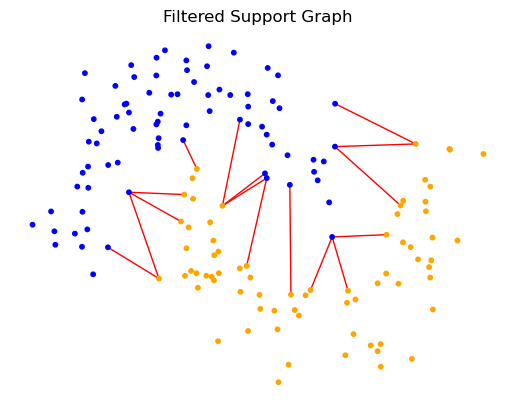

In [157]:
from typing import Self
from sklearn.base import BaseEstimator, ClassifierMixin

class NN_CLAS(BaseEstimator, ClassifierMixin):
  def _quality_array(self, support_graph: np.ndarray) -> np.ndarray:
    """
    Calculate the quality array for the set.

    q_xi = Ĝ(xi) / G(xi)
    where G(xi) is the quantity of edges that link to it
    and Ĝ(xi) is the quantity of edges that link to it and are not support edges.

    Parameters:
    support_graph (np.ndarray): Adjacency matrix of the support graph.

    Returns:
    np.ndarray: Quality array where each element represents the quality of the corresponding vertex.
    """
    G_xi = np.sum(support_graph != Adjacency.NOT_ADJACENT, axis=1)

    G_xi_hat = np.sum(support_graph == Adjacency.GABRIEL_EDGE, axis=1)

    quality = np.divide(G_xi_hat, G_xi, out=np.zeros_like(G_xi, dtype=float), where=G_xi > 0)

    return quality

  def _filter(self, X: np.ndarray, y: np.ndarray,
              distance_matrix: np.ndarray, quality: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Filter the dataset based on the quality array.
    Vertices with quality less than their class's average quality are removed.

    Parameters:
    X (np.ndarray): Coordinates of the vertices.
    y (np.ndarray): Labels for the vertices.
    distance_matrix (np.ndarray): Squared distance matrix.
    quality (np.ndarray): Quality array.

    Returns:
    tuple[np.ndarray, np.ndarray, np.ndarray]: Filtered coordinates, labels, and distance matrix.
    """
    if len(y) == 0 or len(quality) == 0:
      return np.array([]), np.array([]), np.array([[]])

    _, inverse_indices = np.unique(y, return_inverse=True)
    class_avg = np.bincount(inverse_indices, weights=quality) / np.bincount(inverse_indices)

    mask = quality >= class_avg[inverse_indices]

    kept_indices = np.where(mask)[0]
    X_filtered = X[kept_indices]
    y_filtered = y[kept_indices]
    dm_filtered = distance_matrix[np.ix_(kept_indices, kept_indices)]

    return X_filtered, y_filtered, dm_filtered
  
  def _experts(self, X: np.ndarray, y: np.ndarray, support_graph: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Get the experts from the support graph.

    A vertex is an expert if and only if it is linked to a support edge.

    Parameters:
    X (np.ndarray): Coordinates of the vertices.
    y (np.ndarray): Labels for the vertices.
    support_graph (np.ndarray): Adjacency matrix of the support graph.

    Returns:
    np.ndarray: Array of experts coordinates and labels.
    """

    expert_mask = np.any(support_graph == Adjacency.SUPPORT_EDGE, axis=1)

    expert_coords = X[expert_mask]
    expert_labels = y[expert_mask]

    return expert_coords, expert_labels

  def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
    """
    Fit the model to the data.

    Parameters:
    X (np.ndarray): Coordinates of the vertices.
    y (np.ndarray): Labels for the vertices.

    Returns:
    Self: Fitted model.
    """
    self.X_train = X
    self.classes_ = y
    self.dm = distance_matrix(X)
    self.gg = gabriel_graph(self.dm)
    self.sg = support_graph(self.gg, y)
    self.quality = self._quality_array(self.sg)
    self.X_filtered, self.y_filtered, self.dm = self._filter(X, y, self.dm, self.quality)
    self.gg = gabriel_graph(self.dm)
    self.sg = support_graph(self.gg, self.y_filtered)
    self.expert_coords, self.expert_labels = self._experts(self.X_filtered, self.y_filtered, self.sg)

    return self

  def predict(self, X: np.ndarray) -> np.ndarray:
    """
    Predict the labels for the given data.

    Parameters:
    X (np.ndarray): Coordinates of the vertices to predict.

    Returns:
    np.ndarray: Predicted labels.
    """

    distances = cdist(X, self.expert_coords, metric='sqeuclidean')
    
    nearest_expert_indices = np.argmin(distances, axis=1)
    
    return self.expert_labels[nearest_expert_indices]

nn_clas = NN_CLAS()

nn_clas.fit(X_train, y_train)

# Plot the filtered Support graph
plt.title("Filtered Support Graph")
plot_graph(nn_clas.X_filtered, nn_clas.sg, nn_clas.y_filtered, type='support')


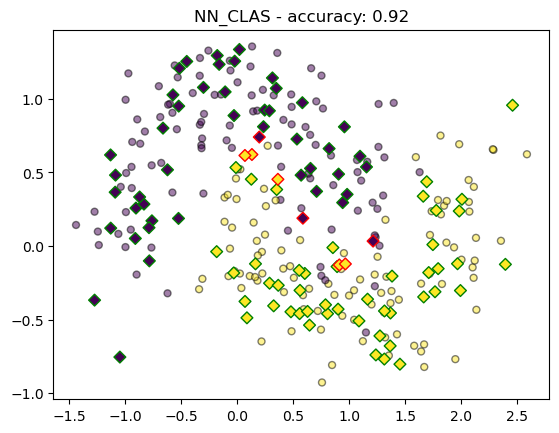

In [158]:
from sklearn.metrics import accuracy_score

y_pred_nnclas = nn_clas.predict(X_test)

def check(X_train: np.ndarray, y_train: np.ndarray,
          X_test: np.ndarray, y_test: np.ndarray,
          y_pred: np.ndarray,
          class_name: str) -> None:
  """
  Check the predictions and print the results.

  Parameters:
  X_train (np.ndarray): Training data.
  y_train (np.ndarray): Training labels.
  X_test (np.ndarray): Test data.
  y_test (np.ndarray): Test labels.
  y_pred (np.ndarray): Predicted labels.
  """

  acc = accuracy_score(y_test, y_pred)

  # Plot train, test, and experts
  plt.figure()

  # Plot train data
  plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='black', alpha=0.5, s=25)

  # Plot test data
  correct = y_pred == y_test
  plt.scatter(X_test[correct, 0], X_test[correct, 1], c=y_pred[correct], edgecolor='green', marker='D')
  plt.scatter(X_test[~correct, 0], X_test[~correct, 1], c=y_pred[~correct], edgecolor='red', marker='D')

  plt.title(f'{class_name} - accuracy: {acc:.2f}')
  plt.show()

check(X_train, y_train, X_test, y_test, y_pred_nnclas, "NN_CLAS")

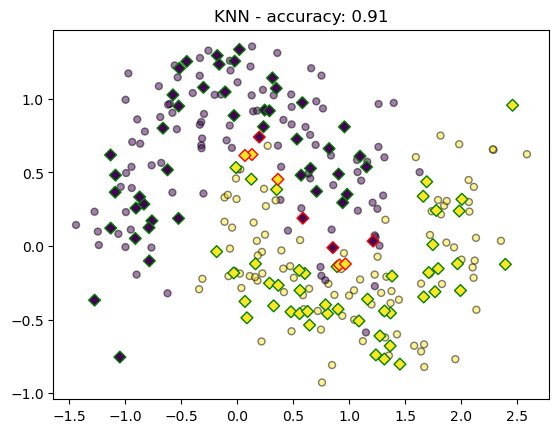

In [ ]:
K = 5

class KNN(BaseEstimator, ClassifierMixin):
  def __init__(self, k: int = 3) -> None:
    """
    Initialize the KNN classifier.

    Parameters:
    k (int): Number of neighbors to consider.
    """
    self.k = k

  def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
    """
    Fit the model to the data.

    Parameters:
    X (np.ndarray): Coordinates of the vertices.
    y (np.ndarray): Labels for the vertices.

    Returns:
    Self: Fitted model.
    """
    self.X_train = X

    unique_values = np.unique(y)
    self.label_map = {unique_values[0]: -1, unique_values[1]: 1}
    self.inverse_label_map = {-1: unique_values[0], 1: unique_values[1]}

    self.classes_ = np.array([self.label_map[label] for label in y.flatten()])

    self.cov = np.cov(X, rowvar=False)

  def predict(self, X: np.ndarray) -> np.ndarray:
    """
    Predict the labels for the given data.

    Parameters:
    X (np.ndarray): Coordinates of the vertices to predict.

    Returns:
    np.ndarray: Predicted labels.
    """

    predictions = []
    for x in X:
      distances = np.array([sq_distance(x, x_train) for x_train in self.X_train])
      nearest_indices = np.argsort(distances)[:self.k]
      scores = np.array([
        self.classes_[idx] * kernel(x.reshape(1, -1), self.X_train[idx].reshape(1, -1), self.cov)[0, 0]
        for idx in nearest_indices
      ])
      predictions.append(self.inverse_label_map[1 if scores.sum() > 0 else -1])
    return np.array(predictions)
  
  def likelihood_score(self, X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculate the likelihood score for the given data.

    Parameters:
    X (np.ndarray): Coordinates of the vertices.
    y (np.ndarray): Labels for the vertices.

    Returns:
    tuple[np.ndarray, np.ndarray]: Likelihood scores for each class.
    """
    Q0 = np.zeros(X.shape[0])
    Q1 = np.zeros(X.shape[0])

    self.fit(X, y)

    distances = cdist(X, self.X_train, metric='sqeuclidean')
    nearest_indices = np.argsort(distances, axis=1)[:, :self.k]

    for i in range(X.shape[0]):
      Q0[i] = sum(
        kernel(X[i].reshape(1, -1), self.X_train[idx].reshape(1, -1), self.cov)[0, 0]
        for idx in nearest_indices[i] if self.classes_[idx] == -1
      )
      Q1[i] = sum(
        kernel(X[i].reshape(1, -1), self.X_train[idx].reshape(1, -1), self.cov)[0, 0]
        for idx in nearest_indices[i] if self.classes_[idx] == 1
      )

    return Q0, Q1

knn = KNN(k=K)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

check(X_train, y_train, X_test, y_test, y_pred_knn, "KNN")

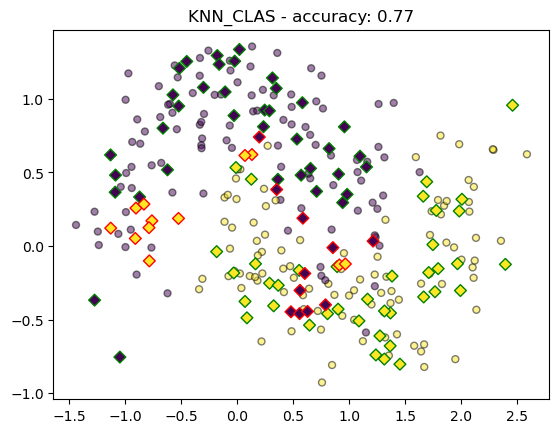

In [ ]:
class KNN_CLAS(BaseEstimator, ClassifierMixin):
  def __init__(self, k: int = 3) -> None:
    """
    Initialize the KNN classifier.

    Parameters:
    k (int): Number of neighbors to consider.
    """
    self.k = k

  def _experts(self, X: np.ndarray, y: np.ndarray, support_graph: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Get the experts from the support graph.

    A vertex is an expert if and only if it is linked to a support edge.

    Parameters:
    X (np.ndarray): Coordinates of the vertices.
    y (np.ndarray): Labels for the vertices.
    support_graph (np.ndarray): Adjacency matrix of the support graph.

    Returns:
    np.ndarray: Array of experts coordinates and labels.
    """

    expert_mask = np.any(support_graph == Adjacency.SUPPORT_EDGE, axis=1)

    expert_coords = X[expert_mask]
    expert_labels = y[expert_mask]

    return expert_coords, expert_labels

  def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
    """
    Fit the model to the data.

    Parameters:
    X (np.ndarray): Coordinates of the vertices.
    y (np.ndarray): Labels for the vertices.

    Returns:
    Self: Fitted model.
    """
    self.X_train = X

    unique_values = np.unique(y)
    self.label_map = {unique_values[0]: -1, unique_values[1]: 1}
    self.inverse_label_map = {-1: unique_values[0], 1: unique_values[1]}

    self.classes_ = np.array([self.label_map[label] for label in y.flatten()])

    self.cov = np.cov(X, rowvar=False)

    self.dm = distance_matrix(X)
    self.gg = gabriel_graph(self.dm)
    self.sg = support_graph(self.gg, y)

    self.expert_coords, self.expert_labels = self._experts(X, y, self.sg)
    self.expert_labels = np.array([self.label_map[label] for label in self.expert_labels])

    return self
  
  def predict(self, X: np.ndarray) -> np.ndarray:
    """
    Predict the labels for the given data.

    Parameters:
    X (np.ndarray): Coordinates of the vertices to predict.

    Returns:
    np.ndarray: Predicted labels.
    """
    distances = cdist(X, self.expert_coords, metric='sqeuclidean')
    nearest_indices = np.argsort(distances, axis=1)[:, :self.k]
    scores = np.array([
      np.sum([
        self.expert_labels[idx] * kernel(X[i].reshape(1, -1), self.expert_coords[idx].reshape(1, -1), self.cov)[0, 0]
        for idx in nearest_indices[i]
      ])
      for i in range(X.shape[0])
    ])
    return np.array([self.inverse_label_map[1 if score > 0 else -1] for score in scores])
  
  def likelihood_score(self, X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculate the likelihood score for the given data.

    Parameters:
    X (np.ndarray): Coordinates of the vertices.
    y (np.ndarray): Labels for the vertices.

    Returns:
    tuple[np.ndarray, np.ndarray]: Likelihood scores for each class.
    """
    Q0 = np.zeros(X.shape[0])
    Q1 = np.zeros(X.shape[0])

    self.fit(X, y)

    distances = cdist(X, self.expert_coords, metric='sqeuclidean')
    nearest_indices = np.argsort(distances, axis=1)[:, :self.k]

    for i in range(X.shape[0]):
      Q0[i] = sum(
        kernel(X[i].reshape(1, -1), self.expert_coords[idx].reshape(1, -1), self.cov)[0, 0]
        for idx in nearest_indices[i] if self.expert_labels[idx] == -1
      )
      Q1[i] = sum(
        kernel(X[i].reshape(1, -1), self.expert_coords[idx].reshape(1, -1), self.cov)[0, 0]
        for idx in nearest_indices[i] if self.expert_labels[idx] == 1
      )

    return Q0, Q1
  
knn_clas = KNN_CLAS(k=K)
knn_clas.fit(X_train, y_train)
y_pred_knn_clas = knn_clas.predict(X_test)

check(X_train, y_train, X_test, y_test, y_pred_knn_clas, "KNN_CLAS")

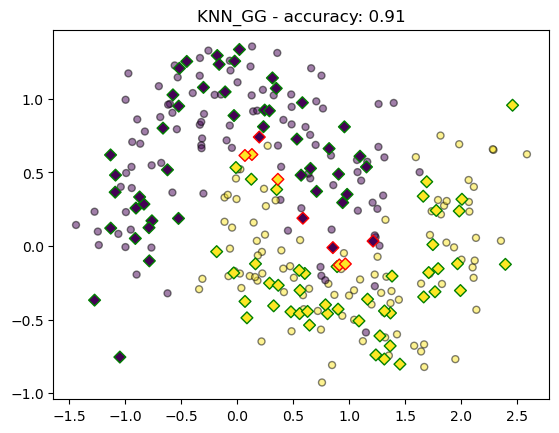

In [ ]:
class KNN_GG(BaseEstimator, ClassifierMixin):
  def __init__(self, k: int = 3) -> None:
    """
    Initialize the KNN classifier.

    Parameters:
    k (int): Number of neighbors to consider.
    """
    self.k = k

  def _experts(self, X: np.ndarray, y: np.ndarray, gabriel_graph: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Get the experts from the gabriel graph.

    A vertex is an expert if and only if it is linked to a gabriel edge.

    Parameters:
    X (np.ndarray): Coordinates of the vertices.
    y (np.ndarray): Labels for the vertices.
    gabriel_graph (np.ndarray): Adjacency matrix of the gabriel graph.

    Returns:
    np.ndarray: Array of experts coordinates and labels.
    """

    expert_mask = np.any(gabriel_graph == Adjacency.GABRIEL_EDGE, axis=1)

    expert_coords = X[expert_mask]
    expert_labels = y[expert_mask]

    return expert_coords, expert_labels

  def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
    """
    Fit the model to the data.

    Parameters:
    X (np.ndarray): Coordinates of the vertices.
    y (np.ndarray): Labels for the vertices.

    Returns:
    Self: Fitted model.
    """
    self.X_train = X

    unique_values = np.unique(y)
    self.label_map = {unique_values[0]: -1, unique_values[1]: 1}
    self.inverse_label_map = {-1: unique_values[0], 1: unique_values[1]}

    self.classes_ = np.array([self.label_map[label] for label in y.flatten()])

    self.cov = np.cov(X, rowvar=False)

    self.dm = distance_matrix(X)
    self.gg = gabriel_graph(self.dm)

    self.expert_coords, self.expert_labels = self._experts(X, y, self.gg)
    self.expert_labels = np.array([self.label_map[label] for label in self.expert_labels])

    return self
  
  def predict(self, X: np.ndarray) -> np.ndarray:
    """
    Predict the labels for the given data.

    Parameters:
    X (np.ndarray): Coordinates of the vertices to predict.

    Returns:
    np.ndarray: Predicted labels.
    """
    distances = cdist(X, self.expert_coords, metric='sqeuclidean')
    nearest_indices = np.argsort(distances, axis=1)[:, :self.k]
    scores = np.array([
      np.sum([
        self.expert_labels[idx] * kernel(X[i].reshape(1, -1), self.expert_coords[idx].reshape(1, -1), self.cov)[0, 0]
        for idx in nearest_indices[i]
      ])
      for i in range(X.shape[0])
    ])
    return np.array([self.inverse_label_map[1 if score > 0 else -1] for score in scores])
  
  def likelihood_score(self, X: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculate the likelihood score for the given data.

    Parameters:
    X (np.ndarray): Coordinates of the vertices.
    y (np.ndarray): Labels for the vertices.

    Returns:
    tuple[np.ndarray, np.ndarray]: Likelihood scores for each class.
    """
    Q0 = np.zeros(X.shape[0])
    Q1 = np.zeros(X.shape[0])

    self.fit(X, y)

    distances = cdist(X, self.expert_coords, metric='sqeuclidean')
    nearest_indices = np.argsort(distances, axis=1)[:, :self.k]

    for i in range(X.shape[0]):
      Q0[i] = sum(
        kernel(X[i].reshape(1, -1), self.expert_coords[idx].reshape(1, -1), self.cov)[0, 0]
        for idx in nearest_indices[i] if self.expert_labels[idx] == -1
      )
      Q1[i] = sum(
        kernel(X[i].reshape(1, -1), self.expert_coords[idx].reshape(1, -1), self.cov)[0, 0]
        for idx in nearest_indices[i] if self.expert_labels[idx] == 1
      )

    return Q0, Q1
  
knn_gg = KNN_GG(k=K)
knn_gg.fit(X_train, y_train)
y_pred_knn_gg = knn_gg.predict(X_test)

check(X_train, y_train, X_test, y_test, y_pred_knn_gg, "KNN_GG")

In [162]:
knn_Q0, knn_Q1 = knn.likelihood_score(X, y)
knn_clas_Q0, knn_clas_Q1 = knn_clas.likelihood_score(X, y)
knn_gg_Q0, knn_gg_Q1 = knn_gg.likelihood_score(X, y)

unique_labels = np.unique(y)
y01 = np.array([0 if label == unique_labels[0] else 1 for label in y])

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(knn_Q0, knn_Q1, c=y01)
plt.title('KNN')
plt.subplot(1, 3, 2)
plt.scatter(knn_clas_Q0, knn_clas_Q1, c=y01)
plt.title('KNN_CLAS')
plt.subplot(1, 3, 3)
plt.scatter(knn_gg_Q0, knn_gg_Q1, c=y01)
plt.title('KNN_GG')
plt.tight_layout()
plt.show()

IndexError: tuple index out of range

# Real data loading

In [ ]:
import os
import numpy as np

sets_directory = './sets/'
datasets = {}

for file_name in os.listdir(sets_directory):
  if file_name.endswith('.npz'):
    file_path = os.path.join(sets_directory, file_name)
    data = np.load(file_path, allow_pickle=True)
    set_name = file_name.split('.')[0]
    datasets[set_name] = {'X': data['X'], 'y': data['y']}
    print(f"Loaded {set_name}: X shape {data['X'].shape}, y shape {data['y'].shape}")

Loaded breast_cancer: X shape (569, 30), y shape (569, 1)
Loaded pima_diabetes: X shape (768, 8), y shape (768, 1)
Loaded spect_heart: X shape (349, 44), y shape (349, 1)
Loaded banknote_authentication: X shape (1372, 4), y shape (1372, 1)
Loaded digits_binary: X shape (360, 64), y shape (360, 1)
Loaded ionosphere: X shape (351, 34), y shape (351, 1)
Loaded haberman_survival: X shape (306, 3), y shape (306, 1)
Loaded sonar: X shape (208, 60), y shape (208, 1)


# Test classifiers on real data

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

SET = 'sonar'
K = 5

X = datasets[SET]['X']
y = datasets[SET]['y'].ravel()

kf = KFold(n_splits=10, shuffle=True)

knn = KNN(k=K)
nn_clas = NN_CLAS()
knn_clas = KNN_CLAS(k=K)
knn_gg = KNN_GG(k=K)

results = []

for model, name in zip([knn, nn_clas, knn_clas, knn_gg], ["KNN", "NN_CLAS", "KNN_CLAS", "KNN_GG"]):
  accuracies, precisions, recalls, f1s = [], [], [], []
  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
    recalls.append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
    f1s.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))

  results.append({
    "Model": name,
    "Accuracy": f"{np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}",
    "Precision": f"{np.mean(precisions):.2f} ± {np.std(precisions):.2f}",
    "Recall": f"{np.mean(recalls):.2f} ± {np.std(recalls):.2f}",
    "F1": f"{np.mean(f1s):.2f} ± {np.std(f1s):.2f}",
  })

results_df = pd.DataFrame(results)
print(results_df)


      Model     Accuracy    Precision       Recall           F1
0       KNN  0.82 ± 0.08  0.84 ± 0.07  0.82 ± 0.08  0.82 ± 0.08
1   NN_CLAS  0.73 ± 0.13  0.75 ± 0.13  0.73 ± 0.13  0.72 ± 0.13
2  KNN_CLAS  0.85 ± 0.08  0.87 ± 0.08  0.85 ± 0.08  0.85 ± 0.08
3    KNN_GG  0.85 ± 0.03  0.87 ± 0.02  0.85 ± 0.03  0.85 ± 0.03


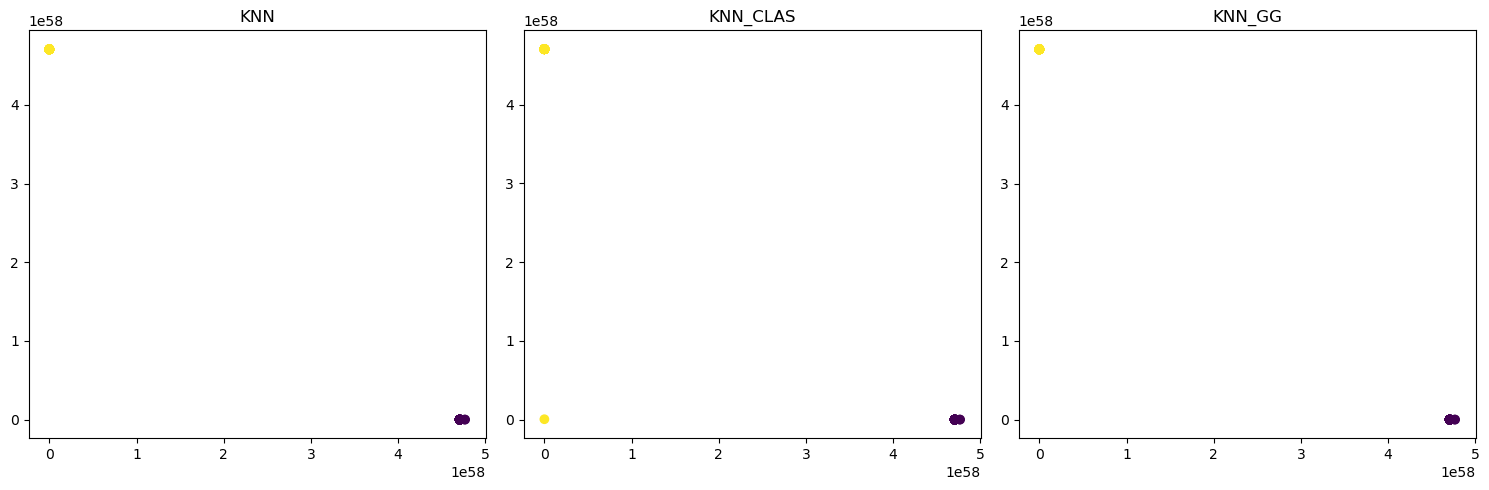

In [ ]:
knn_Q0, knn_Q1 = knn.likelihood_score(X, y)
knn_clas_Q0, knn_clas_Q1 = knn_clas.likelihood_score(X, y)
knn_gg_Q0, knn_gg_Q1 = knn_gg.likelihood_score(X, y)

unique_labels = np.unique(y)
y01 = np.array([0 if label == unique_labels[0] else 1 for label in y])

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(knn_Q0, knn_Q1, c=y01)
plt.title('KNN')
plt.subplot(1, 3, 2)
plt.scatter(knn_clas_Q0, knn_clas_Q1, c=y01)
plt.title('KNN_CLAS')
plt.subplot(1, 3, 3)
plt.scatter(knn_gg_Q0, knn_gg_Q1, c=y01)
plt.title('KNN_GG')
plt.tight_layout()
plt.show()